In [1]:
# Plots for basecalling accuracy with lossy compression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd

In [3]:
compressed_size_dir = '../../data/Staphylococcus_aureus_CAS38_02/compressed_size_summary/'
NUM_EXP = 10 # we tried maxerror parameter from 1 to 10

In [4]:
# load compressed sizes and signal lengths into numpy arrays
# array size = number of reads

with open(compressed_size_dir+'/VBZ_lossless.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
signal_lengths = np.array([int(row[1]) for row in rows[1:]],dtype=int)
lossless_sizes = np.array([int(row[2]) for row in rows[1:]],dtype=int)

LFZip_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)
SZ_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)

for i in range(NUM_EXP):
    with open(compressed_size_dir+'/LFZip_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    LFZip_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    
for i in range(NUM_EXP):
    with open(compressed_size_dir+'/SZ_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    SZ_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    

In [5]:
# compute some totals 
signal_lengths_sum = np.sum(signal_lengths)
lossless_sizes_sum = np.sum(lossless_sizes)
LFZip_sizes_sum = np.sum(LFZip_sizes,axis=1)
SZ_sizes_sum = np.sum(SZ_sizes,axis=1)

In [6]:
# Average compression ratio (bytes/signal value) for lossless compression
print('Lossless compression ratio:','{:.3f}'.format((lossless_sizes_sum/signal_lengths_sum)))

Lossless compression ratio: 0.832


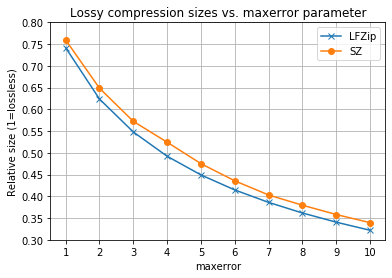

In [7]:
plt.plot(range(1,NUM_EXP+1),LFZip_sizes_sum/lossless_sizes_sum,marker='x')
plt.plot(range(1,NUM_EXP+1),SZ_sizes_sum/lossless_sizes_sum,marker='o')
plt.xticks(range(1,NUM_EXP+1))
plt.yticks([0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8])
plt.xlabel('maxerror')
plt.ylabel('Relative size (1=lossless)')
plt.legend(['LFZip','SZ'])
plt.title('Lossy compression sizes vs. maxerror parameter')
plt.grid()
plt.savefig('pdf_figures/lossy_compression_sizes.pdf')
plt.savefig('png_figures/lossy_compression_sizes.png')

In [8]:
# Now load the basecalling accuracy data (median)
# array size = number of reads
basecalled_accuracy_dir = '../../data/Staphylococcus_aureus_CAS38_02/'

basecallers = ['guppy_hac','guppy_fast','bonito']
basecall_identity = {basecaller: {'lossless':None,'LFZip':np.zeros(NUM_EXP),'SZ':np.zeros(NUM_EXP)} for basecaller in basecallers}

for basecaller in basecallers:
    with open(basecalled_accuracy_dir+basecaller+'/basecaller_accuracy/lossless.fastq.basecall_analysis.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    basecall_identity[basecaller]['lossless'] = np.median(np.array([float(row[2]) for row in rows[1:]]))

for basecaller in basecallers:
    for i in range(NUM_EXP):
        with open(basecalled_accuracy_dir+basecaller+'/basecaller_accuracy/LFZip_maxerror_'+str(i+1)+'.fastq.basecall_analysis.tsv') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            rows = [row for row in reader]
        basecall_identity[basecaller]['LFZip'][i] = np.median(np.array([float(row[2]) for row in rows[1:]]))

    for i in range(NUM_EXP):
        with open(basecalled_accuracy_dir+basecaller+'/basecaller_accuracy/SZ_maxerror_'+str(i+1)+'.fastq.basecall_analysis.tsv') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            rows = [row for row in reader]
        basecall_identity[basecaller]['SZ'][i] = np.median(np.array([float(row[2]) for row in rows[1:]]))

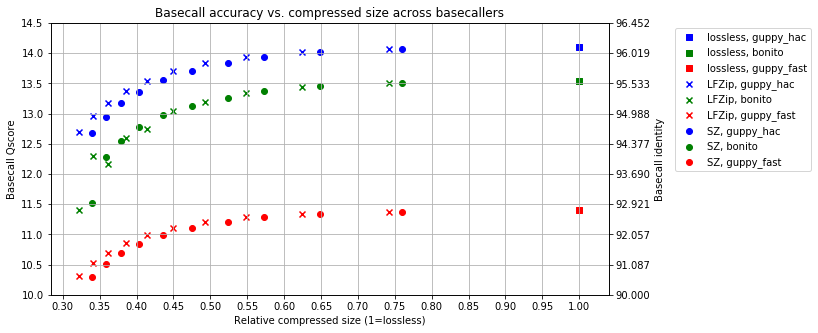

In [9]:
# median basecall accuracy across basecallers

basecallers = ['guppy_hac','bonito','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_fast': 'r','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(basecall_identity[basecaller]['lossless']),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(basecall_identity[basecaller][compressor]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = np.arange(10,15,0.5)
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Basecall Qscore')
ax_phred.set_title('Basecall accuracy vs. compressed size across basecallers')
ax_percent.set_ylabel('Basecall identity')
ax_phred.grid()
plt.savefig('pdf_figures/basecalling_accuracy.pdf',bbox_inches='tight')
plt.savefig('png_figures/basecalling_accuracy.png',bbox_inches='tight')
